# Notebook for Topic modeling visualization. 
<hr>
<ul>
    <li>This notebook is used for the process of social listening.</li>
    <li> This notebook is used for vizualization of the topic modeling process on LDA_NLP.ipynb Notebook</li>
    <li>This notebook is used for Topic clasification.</li>
    <li>Initialy this notebook works with the output of LDA_NLP.ipynb Notebook</li>
</ul>

<h3>
<b>Requirement</b>
</h3>
<hr>
<ul>
    <li> Are required NLP, NLP_viz and AI libraries.</li>
    <li>Require at least one LDA model.</li>
    <li>Require  procesed dataset.</li>
    <li>Require metadata JSON from LDA_NPL.ipynb process</li>
</ul>


In [1]:
import sys
import os

# Get the parent directory of 'topology/'
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)  # Add 'parent/' to Python's path

In [2]:
import config.m365.auth.microsoft_graph as mg

In [3]:
from config import settings, paths
from nlp_lda_optimized import *
from nlp_viz_optimized import *
from AI import *
from dotenv import load_dotenv

El directorio ya existe: C:/Users/Santi/Documents/atinna/repos/escuchas\Azul\espectro_politico\2025-04-01_2025-04-30\v3.0


In [4]:
load_dotenv()
openai_key = os.getenv("openai_api_key")

if not openai_key:
    logger.warning("No OpenAI API key found. Topic naming will be skipped.")

In [5]:
# Autenticación
token_response = mg.authenticate(client_id= settings.id_client, auth= settings.AUTHORITY, scopes= settings.GRAPH_SCOPES)
headers = mg.get_headers(token_response)

✅ Usando sesión existente para santiago.munera@atinna.co


In [6]:
f"{settings.dir_cliente}/{settings.dir_escucha}/{settings.dir_periodo}/{settings.dir_version}"

'Azul/espectro_politico/2025-04-01_2025-04-30/v3.0'

In [7]:
team_id = mg.get_team_id(headers, settings.dir_cliente) if headers else None
sharepoint_site = mg.get_sharepoint_site(headers, team_id)
site_id = sharepoint_site["id"]
drive_items = mg.get_drive_items(headers, site_id)
dev_folder = next((file for file in drive_items if file["name"].lower() == "desarrollo"), None)
dev_folder_id = dev_folder["id"]
dev_files = mg.get_folder_contents(headers, site_id, dev_folder_id)

In [8]:
os.makedirs(paths.paths['local']['output']['lda']['base'], exist_ok=True)
os.makedirs(paths.paths['local']['output']['lda']['models'], exist_ok=True)
os.makedirs(paths.paths['local']['output']['lda']['figures'], exist_ok=True)

In [9]:
id_folder = mg.get_folder_id(headers, site_id, dev_folder_id, paths.paths['cloud']['output']['lda']['base'], separator="/")
mg.download_folder(headers, site_id, id_folder, paths.paths['local']['output']['lda']['base'],create_missing_dirs=True)

ℹ️ La carpeta en SharePoint está vacía.


True

<h1> Data Read</h1>

In [11]:
# Load metadata
path_metadata = os.path.join(paths.paths['local']['output']['lda']['base'], "metadata.json")
metadata = json_read(path_metadata)
metadata.keys()

2025-05-29 18:52:29,409 - INFO - nlp_lda_optimized - json_read - JSON read: C:/Users/Santi/Documents/atinna/repos/escuchas\Azul\espectro_politico\2025-04-01_2025-04-30\v3.0\lda\metadata.json


dict_keys(['LDA_Config', 'Paths', 'Parameters', 'Data_Statistics', 'Execution_Times', 'System_Info', 'Timestamps'])

In [13]:
# Inputs from user.
path_df_processed = os.path.join(paths.paths['local']['output']['lda']['base'], "df_processed.parquet")
path_models = paths.paths['local']['output']['lda']['models']
k = metadata["LDA_Config"]["Recommended_k"]
path_figures =paths.paths['local']['output']['lda']['figures']
path_output = paths.paths['local']['output']['lda']['base']
optimization = True
contexto = "Topicos obtenidos con LDA sobre los comentarios de redes sociales relacionados al espectro politico en colombia"
path_figures
# contexto = 'The contexto of the proyect is : Estamos analizando la conversacion local sobre la salud en Colombia"'

'C:/Users/Santi/Documents/atinna/repos/escuchas\\Azul\\espectro_politico\\2025-04-01_2025-04-30\\v3.0\\lda\\figures'

In [14]:
# File Reading
df = local_reading(path=path_df_processed, lib='polars', format='parquet')
print(df.shape)
df.head(3)

2025-05-29 19:16:30,644 - INFO - nlp_lda_optimized - local_reading - Reading data from: C:/Users/Santi/Documents/atinna/repos/escuchas\Azul\espectro_politico\2025-04-01_2025-04-30\v3.0\lda\df_processed.parquet with library: polars


(2237444, 9)


author,content,date,context,link,domain_group,country,type,processed
str,str,datetime[μs],str,str,str,str,str,list[str]
"""el paisa (@jhonprez60)""","""dios bendiga mi presidente 🙏""",2025-04-10 23:58:54,"""🌎🧳 El presidente de Colombia, …","""https://www.tiktok.com/@ltvhon…","""TikTok""",null,"""Comentario""","[""presidente""]"
null,"""Entre a los comentario como ve…",2025-04-10 23:58:53,"""00:11 ¡Calentando motores! Mar…","""https://www.facebook.com/26301…","""Facebook""","""co""","""Comentario""","[""comentario"", ""mamerta"", … ""arpia""]"
null,"""Fanny Mendoza FANNY LOS DEMAS …",2025-04-10 23:58:52,"""02:04 Ahora presidente de la C…","""https://www.facebook.com/57266…","""Facebook""","""co""","""Comentario""","[""fanny"", ""izquierdo""]"


In [15]:
df['date'].min(), df['date'].max()

(datetime.datetime(2025, 4, 1, 0, 0, 2),
 datetime.datetime(2025, 4, 30, 23, 58, 59))

<h2>Selection of the K value</h2>
<hr>

The coherence grafic help for the k selection. The process give a recommend K value (requiere adjustment). Is recommend the Elbow method, selecting the inflection point for the coherence. Is not strictly necesary, you can select different k values and experiment , the grafic can help you selection  the best K. In theory higer coherence  the better, but also a higer k value can became in dificult task to understand.

In [17]:
path_models

'C:/Users/Santi/Documents/atinna/repos/escuchas\\Azul\\espectro_politico\\2025-04-01_2025-04-30\\v3.0\\lda\\models'

2025-05-29 19:18:46,856 - INFO - nlp_lda_optimized - local_reading - Reading data from: C:/Users/Santi/Documents/atinna/repos/escuchas\Azul\espectro_politico\2025-04-01_2025-04-30\v3.0\lda\models\coherence_summary.parquet with library: polars
2025-05-29 19:18:46,865 - INFO - nlp_viz_optimized - coherence_graphic_process - Loaded coherence results from C:/Users/Santi/Documents/atinna/repos/escuchas\Azul\espectro_politico\2025-04-01_2025-04-30\v3.0\lda\models\coherence_summary.parquet


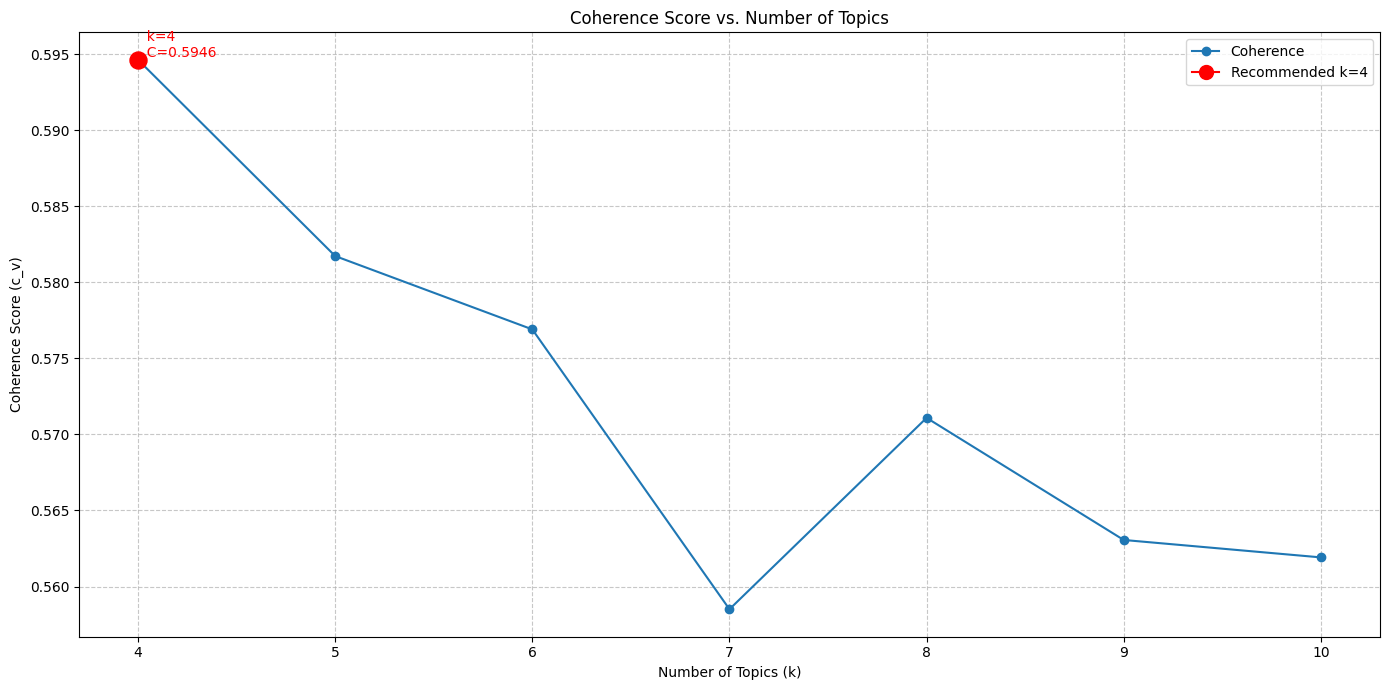

In [19]:
# Coherence Graphic
coherence_graphic_process(k=k, path_models_dir=path_models, coherence_results_filename_base="coherence_summary")

In [20]:
NUM_TOPICS=4
num_words=20

In [21]:
logger.info(f"Iniciando Clasification_Vizualization_lda_process con k={NUM_TOPICS}")

df_out, model = Clasification_Vizualization_lda_process(
    df_processed_text=df,
    NUM_TOPICS=NUM_TOPICS,
    path_models_dir=path_models,
    path_figures_dir=path_figures,
    path_output_data_dir=path_output,
    num_words_display=num_words,
    use_ai_topic_naming=True,
    openai_api_key=openai_key,
    ai_context_for_naming=contexto
)

if df_out is not None:
    logger.info("Proceso de clasificación y visualización completado.")
    # Ahora puedes trabajar con df_clasificado_y_analizado y modelo_lda_cargado
    # print(df_clasificado_y_analizado.head())
else:
    logger.error("El proceso de clasificación y visualización falló.")

2025-05-29 19:19:09,954 - INFO - 2714453934 - <module> - Iniciando Clasification_Vizualization_lda_process con k=4
2025-05-29 19:19:09,955 - INFO - nlp_viz_optimized - Clasification_Vizualization_lda_process - Starting LDA classification and visualization process...
2025-05-29 19:19:09,957 - INFO - nlp_viz_optimized - Clasification_Vizualization_lda_process - Loading LDA model for k=4...
2025-05-29 19:19:09,957 - ERROR - nlp_viz_optimized - Clasification_Vizualization_lda_process - Error loading LDA model: load_gensim_lda_model() got an unexpected keyword argument 'path_models'


UnboundLocalError: cannot access local variable 'lda_model' where it is not associated with a value

In [19]:
df_out, model = Clasification_Vizualization_lda_process(
    df=df,
    NUM_TOPICS=NUM_TOPICS,
    path_models=path_models,
    path_output=path_output,
    path_figures=path_figures,
    num_words=num_words,
    optimization=True,
    Topic_assistant=True,
    assistant_key=openai_key,
    contexto=contexto,
)

TypeError: Clasification_Vizualization_lda_process() got an unexpected keyword argument 'df'

In [ ]:
df_out.shape

## Word importance and count for each topic.

In [22]:
word_relevance= [local_reading(path=path_output+i) for i in os.listdir(path_output) if 'words_global'in i]
word_relevance[0]

# Topic distribution

In [ ]:
df_out.shape

In [ ]:
df_out['Topic'].value_counts().to_frame()

In [ ]:
#Percentage
df_out['Topic'].value_counts(normalize=True).to_frame()

# Sync

In [ ]:
mg.upload_folder(headers, site_id, dev_folder_id, paths.paths['local']['output']['lda']['base'], paths.paths['cloud']['output']['lda']['base'], separator="/", conflict_behavior="fail", skip_on_error=False)